# Import Data

In [10]:
import tensorflow
import keras
import numpy as np
np.random.seed(1248)

In [11]:
import pandas as pd

In [12]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [13]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [14]:
x = pd.read_csv("../data/buffer_overflow_graph_embeddings.csv.gz")
x['testcase_ID'] = x['type']
del x['type']
x = x.sort_values("testcase_ID").reset_index(drop=True)

In [15]:
y = labels['bug']
x = x.drop('testcase_ID', axis='columns')

In [16]:
import sklearn

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [18]:
import pickle

with open('../data/x-train-binary','wb') as f:
    pickle.dump(x_train,f)
    
with open('../data/y-train-binary','wb') as f:
    pickle.dump(y_train,f)
    
with open('../data/x-test-binary','wb') as f:
    pickle.dump(x_test,f)
    
with open('../data/y-test-binary','wb') as f:
    pickle.dump(y_test,f)

In [11]:
y_train.shape

(10751,)

In [12]:
x_train.shape

(10751, 128)

# [Neural tutorial](https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7)

In [13]:
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam

In [14]:
n_timesteps, n_features, n_outputs = x_train.shape[0], x_train.shape[1], y_train.shape[0]

In [15]:
model = Sequential()
conv_model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

# model.add(Dense(128, input_dim=x_train.shape[1], activation='sigmoid'))
# model.add(Reshape((-1,3), input_shape=(128,)))
conv_model.add(Conv1D(filters = 64, kernel_size = 3, input_shape = (n_timesteps, n_features), activation ='sigmoid'))
conv_model.add(Dropout(0.5))
conv_model.add(MaxPooling1D(pool_size = 2, padding = 'same'))
# model.add(Flatten())
conv_model.add(Dense(n_outputs, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# from sklearn.neural_network import MLPClassifier
# clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 33,153
Trainable params: 33,153
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=50, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
10751/10751 [==============================] - 1s 99us/step - loss: 0.6932 - acc: 0.5203
Epoch 2/50
10751/10751 [==============================] - 0s 33us/step - loss: 0.6761 - acc: 0.5806
Epoch 3/50
10751/10751 [==============================] - 0s 34us/step - loss: 0.6580 - acc: 0.6089
Epoch 4/50
10751/10751 [==============================] - 0s 33us/step - loss: 0.6309 - acc: 0.6606
Epoch 5/50
10751/10751 [==============================] - 0s 34us/step - loss: 0.6165 - acc: 0.6731: 0s - loss: 0.6156 - acc: 0
Epoch 6/50
10751/10751 [==============================] - 0s 32us/step - loss: 0.5974 - acc: 0.6924
Epoch 7/50
10751/10751 [==============================] - 0s 41us/step - loss: 0.5801 - acc: 0.7100
Epoch 8/50
10751/10751 [==============================] - 0s 37us/step - loss: 0.5624 - acc: 0.7194
Epoch 9/50
10751/10751 [==============================] - 0s 42us/step - loss: 0.5497 - acc: 0.7246
Epoch 10/50
10751/10751 

In [20]:
import pickle

In [21]:
with open('../data/baseline-model-binary','wb') as f:
    pickle.dump(model,f)

In [30]:
model.evaluate(x_test,y_test)

10751/10751 [==============================] - 0s 38us/step


[0.18332740306818213, 0.9168449445731495]

In [26]:
!pip install seaborn

In [19]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [20]:
y_predict= model.predict(x_test)

In [21]:
import numpy as np

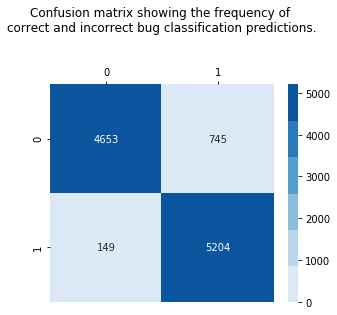

In [31]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 4)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

confusion_figure.savefig('../images/baseline_conf_matrix')

In [24]:
# confusion_matrices = metrics.multilabel_confusion_matrix(
#     (y_test+0).values,
#     np.rint(y_predict)
# )

In [25]:
# for label, confusion_matrix in zip(y_test.columns, confusion_matrices):

#     confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
#     confusion_figure.set_size_inches(2, 1)
#     confusion_axes.set_title(
#         label + 
#         '\n'  # hack to avoid overlap with x-axis labels below
#     )
#     confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
#     _ = sns.heatmap(
#         confusion_matrix,
#         annot=True,
#         fmt="d",
#         cmap=sns.color_palette("Blues"),
#         vmin=0,
#         ax=confusion_axes,
#     )

AttributeError: 'Series' object has no attribute 'columns'

In [27]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve((y_test.values+0), y_predict)

In [28]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
auc_keras = auc(fpr_keras, tpr_keras)

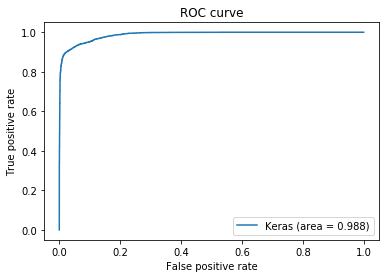

<Figure size 432x288 with 0 Axes>

In [32]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig('../images/baseline_roc_curve')

In [ ]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix((y_test.values+0).argmax(axis=1), y_predict.argmax(axis=1)), 
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(10, 8)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [72]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [75]:
rf.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.4053359315636961

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf1 = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf1.fit(x_train, y_train)

In [ ]:
rf1.score(x_test, y_test)

In [2]:
from pyspark import SparkContext
import os 

# this should be JAVA_HOME path
os.environ['JAVA_HOME']="/Library/Java/JavaVirtualMachines/jdk1.8.0_202.jdk/Contents/Home/"

os.environ['PYSPARK_SUBMIT_ARGS'] = "--master local[2] pyspark-shell"

sc = SparkContext.getOrCreate()

In [13]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("test").getOrCreate()

In [16]:
xtemp = x_test.values.tolist()

In [32]:
temp = pd.DataFrame()

In [29]:
df = spark.createDataFrame()

TypeError: createDataFrame() missing 1 required positional argument: 'data'

In [1]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'result', labelCol = 'categorylabel')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'prediction', 'probability').show(10)

AttributeError: Cannot load _jvm from SparkContext. Is SparkContext initialized?

In [ ]:
from pyspark.ml.classification import LogisticRegression
train, test = indexed.randomSplit([0.8, 0.2], seed = 7*4*25)
